In [1]:
# Model Configuration
UNITS = 2 ** 11 # 2048
ACTIVATION = 'relu'
DROPOUT = 0.1

# Training Configuration
BATCH_SIZE_PER_REPLICA = 2 ** 11 # powers of 128 are best

In [2]:
# TensorFlow
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

# Detect and init the TPU
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)
    
# Plotting
import pandas as pd
import matplotlib.pyplot as plt

# Matplotlib defaults
# plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


# Data
from kaggle_datasets import KaggleDatasets
from tensorflow.io import FixedLenFeature
AUTO = tf.data.experimental.AUTOTUNE


# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

2025-09-15 22:00:55.539630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-15 22:00:55.539769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-15 22:00:55.686123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.15.0
Number of accelerators:  1


In [3]:
def make_decoder(feature_description):
    def decoder(example):
        example = tf.io.parse_single_example(example, feature_description)
        features = tf.io.parse_tensor(example['features'], tf.float32)
        features = tf.reshape(features, [28])
        label = example['label']
        return features, label
    return decoder

def load_dataset(filenames, decoder, ordered=False):
    AUTO = tf.data.experimental.AUTOTUNE
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = (
        tf.data
        .TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .with_options(ignore_order)
        .map(decoder, AUTO)
    )
    return dataset

In [4]:
dataset_size = int(11e6)
validation_size = int(5e5)
training_size = dataset_size - validation_size

# For model.fit
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = training_size // batch_size
validation_steps = validation_size // batch_size

# For model.compile
steps_per_execution = 256

In [5]:
feature_description = {
    'features': FixedLenFeature([], tf.string),
    'label': FixedLenFeature([], tf.float32),
}
decoder = make_decoder(feature_description)

data_dir = KaggleDatasets().get_gcs_path('higgs-boson')
train_files = tf.io.gfile.glob(data_dir + '/training' + '/*.tfrecord')
valid_files = tf.io.gfile.glob(data_dir + '/validation' + '/*.tfrecord')

ds_train = load_dataset(train_files, decoder, ordered=False)
ds_train = (
    ds_train
    .cache()
    .repeat()
    .shuffle(2 ** 19)
    .batch(batch_size)
    .prefetch(AUTO)
)

ds_valid = load_dataset(valid_files, decoder, ordered=False)
ds_valid = (
    ds_valid
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

In [6]:
def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    def make(inputs):
        x = layers.Dense(units)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    return make

with strategy.scope():
    # Wide Network
    wide = keras.experimental.LinearModel()

    # Deep Network
    inputs = keras.Input(shape=[28])
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(inputs)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    outputs = layers.Dense(1)(x)
    deep = keras.Model(inputs=inputs, outputs=outputs)
    
    # Wide and Deep Network
    wide_and_deep = keras.experimental.WideDeepModel(
        linear_model=wide,
        dnn_model=deep,
        activation='sigmoid',
    )

wide_and_deep.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['AUC', 'binary_accuracy'],
    experimental_steps_per_execution=steps_per_execution,
)

In [7]:
early_stopping = callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)

In [ ]:
history = wide_and_deep.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_schedule],
)

Epoch 1/50


I0000 00:00:1757973696.109484      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5126/5126 [==============================] - 437s 85ms/step - loss: 0.5059 - auc: 0.8286 - binary_accuracy: 0.7469 - val_loss: 0.4753 - val_auc: 0.8511 - val_binary_accuracy: 0.7668 - lr: 0.0010
Epoch 2/50
5126/5126 [==============================] - 231s 45ms/step - loss: 0.4710 - auc: 0.8540 - binary_accuracy: 0.7697 - val_loss: 0.4614 - val_auc: 0.8605 - val_binary_accuracy: 0.7752 - lr: 0.0010
Epoch 3/50
5126/5126 [==============================] - 231s 45ms/step - loss: 0.4593 - auc: 0.8620 - binary_accuracy: 0.7772 - val_loss: 0.4507 - val_auc: 0.8678 - val_binary_accuracy: 0.7821 - lr: 0.0010
Epoch 4/50
5126/5126 [==============================] - 231s 45ms/step - loss: 0.4513 - auc: 0.8673 - binary_accuracy: 0.7822 - val_loss: 0.4449 - val_auc: 0.8716 - val_binary_accuracy: 0.7864 - lr: 0.0010
Epoch 5/50
5126/5126 [==============================] - 230s 45ms/step - loss: 0.4450 - auc: 0.8713 - binary_accuracy: 0.7861 - val_loss: 0.4400 - val_auc: 0.8745 - val_binary_accuracy: 0

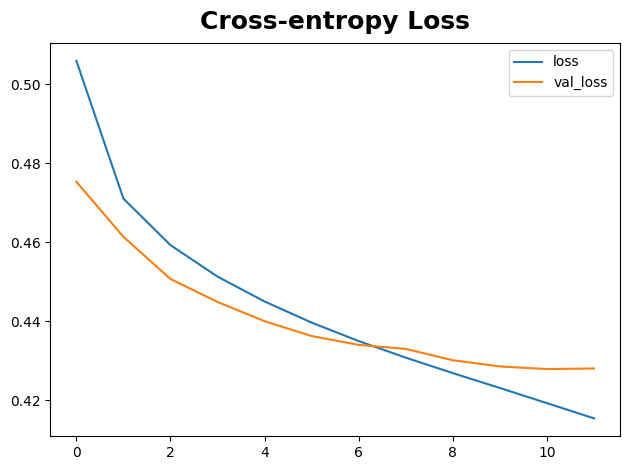

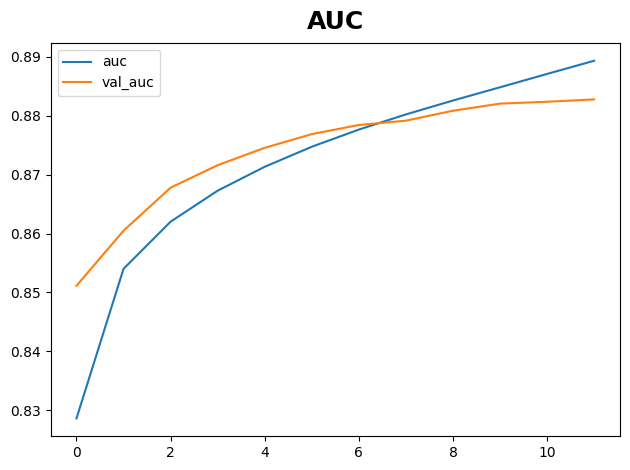

In [10]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot(title='Cross-entropy Loss')
history_frame.loc[:, ['auc', 'val_auc']].plot(title='AUC');